# **긴 시계열의 대표 패턴 추출 방법 연구 (2)**

### 창원대 전자공학과 20145234 황주효 (Hwang Ju-hyo, Department of Electronic Engineering, Changwon University)
---

* 짧은 시계열(120초 미만)의 경우, 여러 시계열 유사도 비교 방법을 사용하여 비슷한 패턴을 추출하고 이를 TimeKMeans 클러스터링과 DBA를 이용해 대표 패턴 추출이 가능하다.

* 그러나 실제 제조 데이터를 보면 자주 관측할 수 있는 패턴이 120초 이상인 경우가 많다. 이를 위의 방법으로 그대로 시행하면 시간이 매우 오래 걸리고, 심지어 새로운 데이터가 생길때마다 모든 과정을 새로 시행해야한다. 더군다나 시간이 자면 데이터가 많이 쌓일텐데 이를 모두 클러스터링하기에는 시간 자원이 부족하다.

* 따라서 이를 해결하기 위해 우리는 시계열의 차원 축소를 행해야하고 이를 AutoEncoder를 이용해 수행해본다.

과정은 다음과 같다.
1. 데이터 관찰 및 STL 사용
2. AutoEncoder 훈련
3. Encoder의 출력으로 TimeKMeans 클러스터링 및 Kmeans 클러스터링 대표패턴 추출, T-sne, Umap 매핑

In [1]:
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

with open("extract_padding.pickle","rb") as fr:
    df = pickle.load(fr)

In [2]:
data = df['main_powe']
data.shape

(326, 4000)

In [3]:
data = data.reshape(326, 4000, 1)
data.shape

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## 인코더 차원 : 500

In [4]:
timesteps = 4000
n_features = 1

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Flatten, MaxPooling1D, UpSampling1D, Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout

import tensorflow as tf
# define model

visible = Input(shape = (timesteps, n_features))
encoder = Conv1D(64, 3500, activation='relu', padding = 'same')(visible)
x = BatchNormalization()(encoder)
x = MaxPooling1D(2, padding = 'same')(x)

x = Conv1D(64, 200, activation='relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding = 'same')(x)

x = Conv1D(128, 50, activation='relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding = 'same')(x)


x = Conv1D(1, 1, activation='relu', padding = 'same')(x)
mid_output = BatchNormalization()(x)
x =  UpSampling1D(2)(mid_output)

x = Conv1D(128, 50, activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x =  UpSampling1D(2)(x)

x = Conv1D(64, 64, activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x =  UpSampling1D(2)(x)

x = Conv1D(64, 50, activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)

x = Conv1D(1, 1, activation = 'sigmoid', padding = 'same')(x)
decoder = BatchNormalization()(x)

op = tf.keras.optimizers.Adam(lr = 0.001)
autoencoder = Model(inputs=visible, outputs = decoder)
autoencoder.compile(optimizer = op, loss = 'mae')
autoencoder.summary()

encoder = Model(inputs=autoencoder.inputs, outputs=mid_output)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4000, 64)          224064    
_________________________________________________________________
batch_normalization (BatchNo (None, 4000, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 64)          819264    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 64)          0     

In [5]:
from tensorflow import keras

autoencoder = keras.models.load_model('cnn_autoencoder_powe.h5')
encoder = keras.models.load_model('cnn_encoder_powe.h5')

In [6]:
input_shape = autoencoder.layers[12].get_input_shape_at(0)
layer_input = Input(shape = (500, 1))

x = layer_input
for layer in autoencoder.layers[12:]:
    x = layer(x)
    
decoder_2 = Model(inputs = layer_input, outputs = x)

In [7]:
from datetime import datetime
import os
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

logdir="logs/ae_powe" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
es = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 40)
mc = ModelCheckpoint('powe_best_model.h5', monitor = 'val_loss', save_best_only = True)

checkpoint_path = 'logs/ck/ae_powe/training/cp-{epoch:04d}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = checkpoint_path,
verbose = 0,
save_weights_only= True,
period = 10)

In [8]:
np.random.seed(77)
np.random.shuffle(data)

In [9]:
history = autoencoder.fit(data, data, epochs = 500, validation_split = 0.1,
                          batch_size = 8, callbacks=[tensorboard_callback, cp_callback, es, mc],
                         verbose = 0)

Epoch 00454: early stopping


In [10]:
"""autoencoder.save('cnn_autoencoder_powe.h5')
encoder.save('cnn_encoder_powe.h5')"""

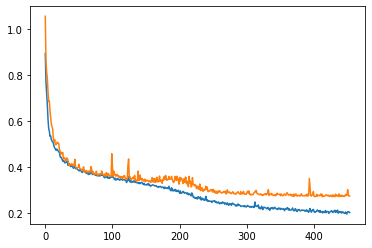

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(history.history['loss'])),history.history['loss'])
plt.plot(range(len(history.history['loss'])),history.history['val_loss'])

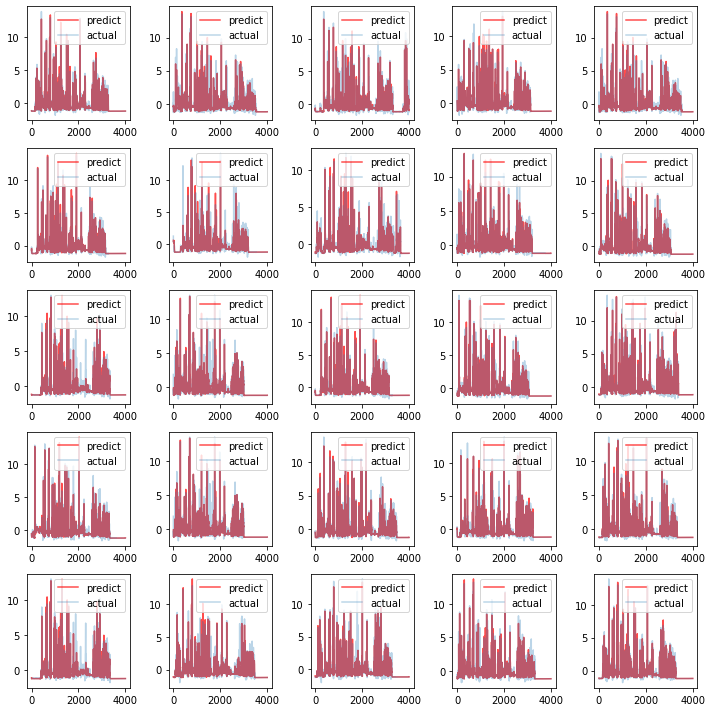

In [7]:
import matplotlib.pyplot as plt
X = data

for s in range(0, 1):
    fig, axes = plt.subplots(5, 5, figsize = (10, 10))
    for y in range(0, 5):
        for x in range(0, 5):
            n = np.random.choice(100)
            axes[y][x].plot(autoencoder.predict(X[n].reshape(1, 4000, 1)).reshape(4000, 1), 'r-', label = 'predict', alpha = 0.7)
            axes[y][x].plot(X[n], label = 'actual', alpha = 0.3)
            axes[y][x].legend()
            
    s = s+1
   
    plt.tight_layout()

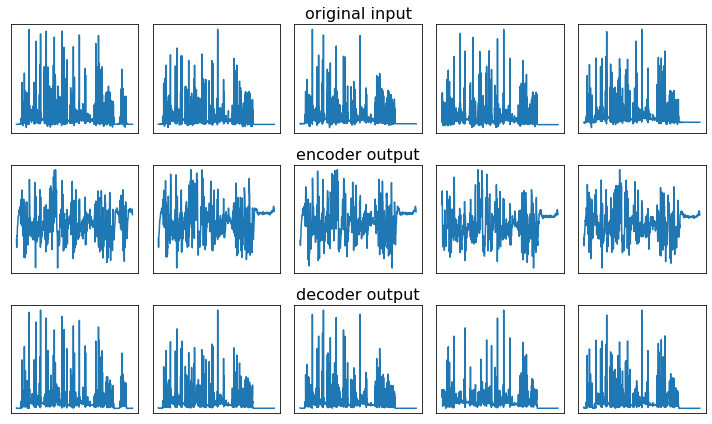

--------------------------------------------------------------------------


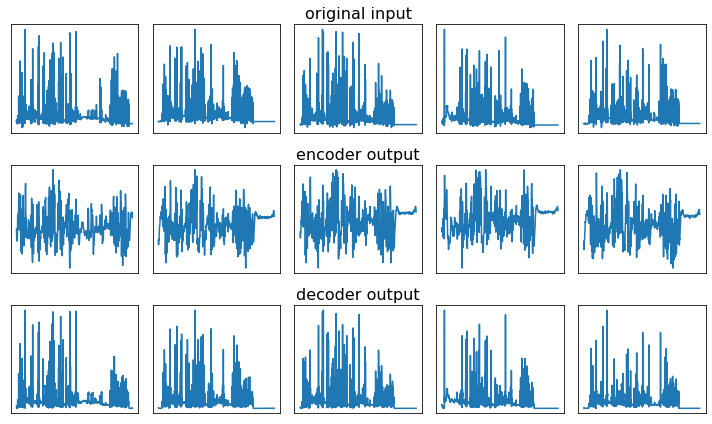

--------------------------------------------------------------------------


In [8]:
import pandas as pd

tmp = encoder.predict(X)
for j in range(2):
    fig, ax = plt.subplots(3, 5, figsize = (10, 6))
    for i in range(5):
       
        n = np.random.choice(100)

        ax[0][i].plot(range(4000), X[n])
        ax[0][i].yaxis.set_visible(False)
        ax[0][i].xaxis.set_visible(False)
        ax[0][2].set_title('original input', {'fontsize' : 16})

        ax[1][i].plot(range(500),tmp[n].flatten())
        ax[1][i].yaxis.set_visible(False)
        ax[1][i].xaxis.set_visible(False)
        ax[1][2].set_title('encoder output', {'fontsize' : 16})

        ax[2][i].plot(range(4000),autoencoder.predict(X)[n])
        ax[2][i].yaxis.set_visible(False)
        ax[2][i].xaxis.set_visible(False)
        ax[2][2].set_title('decoder output', {'fontsize' : 16})

    plt.tight_layout()
    plt.show()
    print('--------------------------------------------------------------------------')

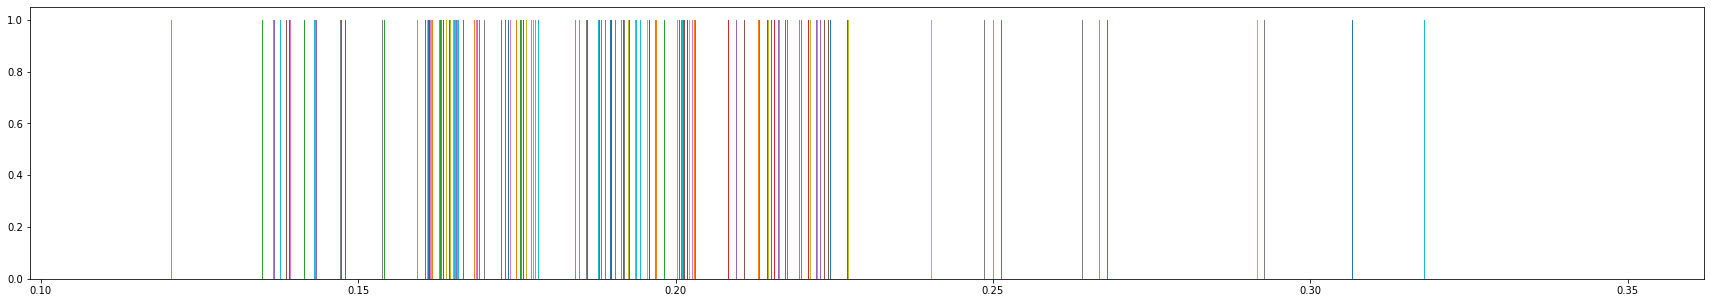

In [15]:
reconstructions = autoencoder.predict(X)
reconstructions = reconstructions.reshape(326, 4000)
train_loss = tf.keras.losses.mae(reconstructions, X.reshape(reconstructions.shape))
plt.figure(figsize = (30, 5))
plt.hist(train_loss, bins = 10)
plt.show()

In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.22946502478056022


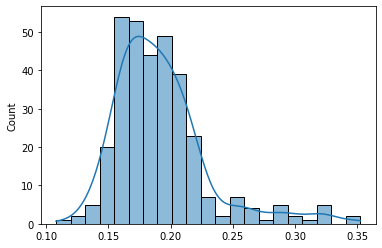

In [17]:
import seaborn as sns
sns.histplot(train_loss, kde = True)
plt.show()

In [18]:
"""model.save('cnn_autoencoder.h5')
model2.save('cnn_encoder.h5')"""

"model.save('cnn_autoencoder.h5')\nmodel2.save('cnn_encoder.h5')"

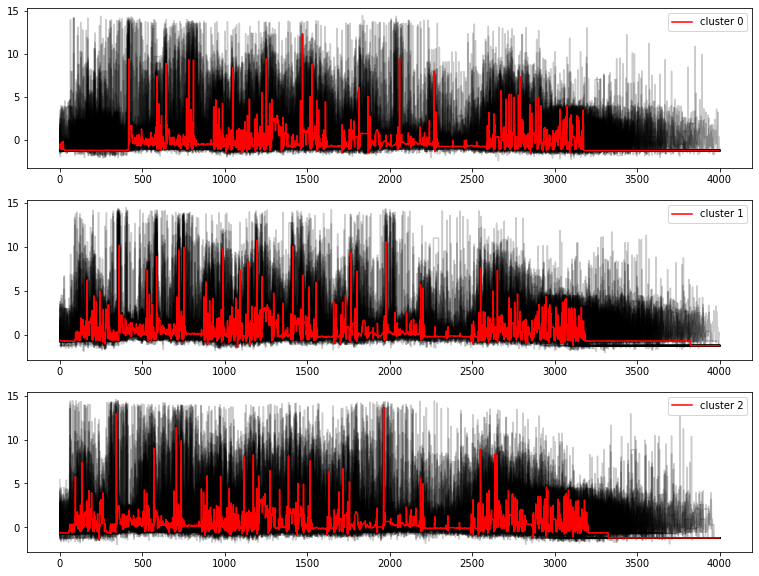

In [19]:
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
import pandas as pd

Y = encoder.predict(X).reshape(326, 500)
km = KMedoids(n_clusters=3, init = 'k-medoids++', max_iter = 300, random_state = 777)

cobj = km.fit(Y)
t = km.predict(Y)
labels = cobj.labels_

fig, ax = plt.subplots(3, 1, figsize=(13, 10))

for yi in range(3):
    for xx in X[t == yi]:
        ax[yi].plot(xx.ravel(), "k-", alpha=.2)
    nm = X[pd.DataFrame(np.where(Y == cobj.cluster_centers_[yi])[0]).value_counts().index[0]]    
    ax[yi].plot(range(len(nm)), nm, 'r-', label = 'cluster {}'.format(yi))    
    ax[yi].legend()
plt.show()

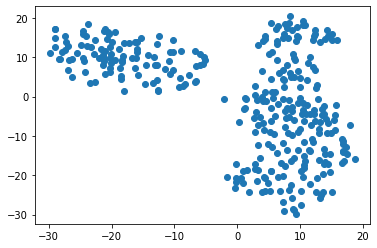

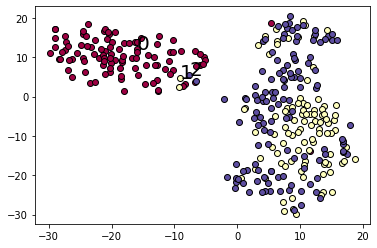

In [20]:
tsne = TSNE(learning_rate=300, n_components=2)
transformed = tsne.fit_transform(Y)

fig = plt.figure()
plt.scatter(transformed.T[0], transformed.T[1])
plt.show()

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = transformed[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    
    plt.text(
       xy[:, 0][0],
        xy[:, 1][0],
        s = '{}'.format(k),
        fontsize = 20
    )

plt.show()

In [21]:
import umap
km2 = km
umaps = umap.UMAP(n_neighbors = 50)
embedding = umaps.fit_transform(Y)
t2 = km2.predict(Y)
labels = cobj.labels_

new = []
for i in range(3):
    new.append(umaps.transform(km.cluster_centers_[i].reshape(1, 500)))

inside function
   (0, 0)	0.09609383
  (0, 1)	0.102513775
  (0, 2)	0.21328257
  (0, 6)	0.093360394
  (0, 7)	0.09127057
  (0, 15)	0.101608194
  (0, 16)	0.08714655
  (0, 18)	0.11970048
  (0, 20)	0.10244094
  (0, 22)	0.12768032
  (0, 24)	0.15717238
  (0, 25)	0.10054917
  (0, 27)	0.09235787
  (0, 28)	0.10601707
  (0, 29)	0.11356615
  (0, 30)	0.15956962
  (0, 33)	0.15756288
  (0, 35)	0.13369857
  (0, 36)	0.08905436
  (0, 37)	0.099087894
  (0, 42)	0.15103489
  (0, 43)	0.16700216
  (0, 44)	0.14701217
  (0, 48)	0.090564616
  (0, 51)	0.12896949
  (0, 52)	0.12043902
  (0, 53)	0.1285468
  (0, 57)	0.10298257
  (0, 58)	0.10293004
  (0, 60)	0.17794147
  (0, 61)	0.09578986
  (0, 63)	0.10240624
  (0, 64)	0.09183609
  (0, 66)	0.09343265
  (0, 69)	0.08870349
  (0, 71)	0.13703293
  (0, 73)	1.0
  (0, 75)	0.08889064
  (0, 76)	0.18264373
  (0, 79)	0.08905748
  (0, 84)	0.17639284
  (0, 89)	0.088555574
  (0, 90)	0.099353716
  (0, 91)	0.093788475
  (0, 92)	0.09618107
  (0, 94)	0.08714142
  (0, 99)	0.09212989
 

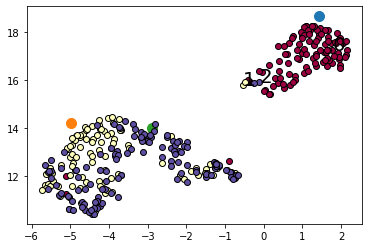

In [22]:
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = embedding[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    
    plt.text(
       xy[:, 0][0],
        xy[:, 1][0],
        s = '{}'.format(k),
        fontsize = 20
    )
    
for i in range(3):
    plt.scatter(new[i][0][0], new[i][0][1], s = 100)

plt.show()

In [20]:
from tslearn.clustering import TimeSeriesKMeans
import time

In [21]:
start = time.time()
km = TimeSeriesKMeans(n_clusters = 3, metric = 'dtw', max_iter = 50, n_init = 5, n_jobs = -1).fit(Y)
print("time :", time.time() - start)

time : 967.3564991950989


In [26]:
new = []

for i in range(3):
    new.append(umaps.transform(km.cluster_centers_[i].reshape(1, 500)))

inside function
   (0, 32)	0.09375201
  (0, 34)	0.10739394
  (0, 47)	0.109367415
  (0, 59)	0.112979226
  (0, 65)	0.10584543
  (0, 72)	0.096472695
  (0, 82)	0.14784227
  (0, 86)	0.09605565
  (0, 109)	0.14724538
  (0, 110)	0.10291522
  (0, 140)	0.15058787
  (0, 141)	0.13813017
  (0, 149)	0.11044443
  (0, 150)	0.11395249
  (0, 151)	0.10678113
  (0, 152)	0.12260689
  (0, 158)	0.12076644
  (0, 163)	0.09782154
  (0, 165)	0.09647299
  (0, 166)	0.101680845
  (0, 169)	0.10807768
  (0, 173)	0.09366459
  (0, 177)	0.13970827
  (0, 178)	0.11300318
  (0, 182)	0.1078343
  (0, 183)	0.09568897
  (0, 195)	0.14675808
  (0, 204)	0.123122394
  (0, 205)	0.12279616
  (0, 214)	0.13163449
  (0, 220)	0.1314358
  (0, 223)	0.099600874
  (0, 224)	0.10629198
  (0, 255)	0.09676331
  (0, 262)	0.09293123
  (0, 274)	0.10449479
  (0, 279)	0.09728044
  (0, 286)	0.098025076
  (0, 289)	0.4555704
  (0, 292)	0.09326362
  (0, 296)	0.10047302
  (0, 298)	0.15178703
  (0, 303)	0.1141511
  (0, 304)	0.09966779
  (0, 306)	0.1293280

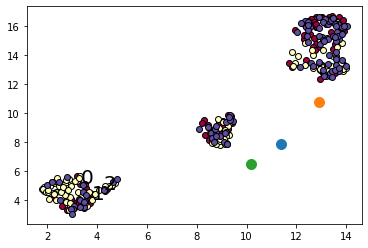

In [27]:
t2 = km.predict(Y)
cobj = km
labels = cobj.labels_
new = []

for i in range(3):
    new.append(umaps.transform(km.cluster_centers_[i].reshape(1, 500)))

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = embedding[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    
    plt.text(
       xy[:, 0][0],
        xy[:, 1][0],
        s = '{}'.format(k),
        fontsize = 20
    )

for i in range(3):
    plt.scatter(new[i][0][0], new[i][0][1], s = 100)

plt.show()